In [5]:
from distributions.spiral import sample_spiral_distribution
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from flows.network import NormalizingFlow, flow_loss
import yaml
from types import SimpleNamespace
import matplotlib.pyplot as plt
from matplotlib import cm
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def dict_to_namespace(d):
    def convert_value(v):
        if isinstance(v, dict):
            return dict_to_namespace(v)
        if isinstance(v, str):
            try:
                return float(v)
            except ValueError:
                return v  # leave as string if it can't be converted
        return v
    return SimpleNamespace(**{k: convert_value(v) for k, v in d.items()})

with open("configs.yaml") as f:
    config = yaml.safe_load(f)
config = dict_to_namespace(config)

In [6]:
config

namespace(flow=namespace(input_dim=2,
                         hidden_dim=64,
                         hidden_layers=5,
                         output_dim=2,
                         nflows=10,
                         learning_rate=1e-05,
                         weight_decay=1e-05,
                         device='cuda',
                         batch_size=128,
                         epochs=1000),
          triangular=namespace(input_dim=2,
                               hidden_dim=16,
                               hidden_layers=10,
                               device='cuda',
                               weight_decay=1e-05,
                               batch_size=128,
                               epochs=200,
                               learning_rate=0.0001))

In [7]:
X = sample_spiral_distribution(10000)
X = torch.tensor(X, dtype=torch.float32)
# Normalize (standardization)
mean = X.mean(dim=0)
std = X.std(dim=0)
X_norm = (X - mean) / std

# Wrap in dataset
dataset = TensorDataset(X_norm)
loader = DataLoader(dataset, batch_size=config.flow.batch_size, shuffle=True)
flow = NormalizingFlow(config.flow).to(config.flow.device)

In [8]:
for epoch in range(config.flow.epochs):
    for batch in loader:
        x = batch[0].to(config.flow.device)
        z, log_det = flow(x)
        loss = flow_loss(z, log_det)
        flow.optimizer.zero_grad()
        loss.backward()
        flow.optimizer.step()
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

KeyboardInterrupt: 

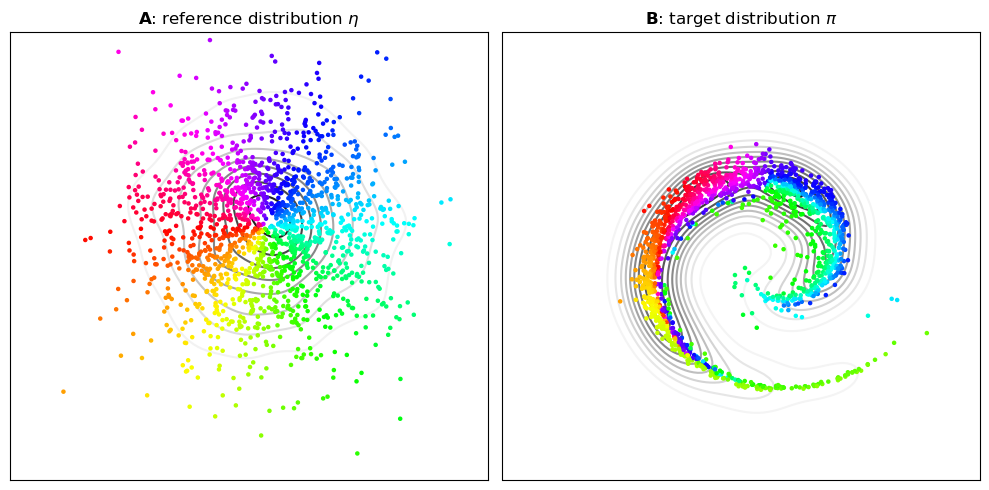

In [ ]:
from sklearn.neighbors import KernelDensity
# Helper to compute KDE for contours
def get_kde_contour(samples, bounds=(-6, 6), n=100, bandwidth=0.1):
    x_grid = np.linspace(bounds[0], bounds[1], n)
    y_grid = np.linspace(bounds[0], bounds[1], n)
    xx, yy = np.meshgrid(x_grid, y_grid)
    xy = np.stack([xx.ravel(), yy.ravel()], axis=1)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples)
    zz = np.exp(kde.score_samples(xy)).reshape(xx.shape)
    return xx, yy, zz

# 5. Visualize samples from the trained flow
with torch.no_grad():
    x,z = flow.sample(1500)
    x = x.cpu().numpy()
    z = z.cpu().numpy()
colors = cm.hsv((np.arctan2(z[:, 1], z[:, 0]) + np.pi) / (2 * np.pi))  # color by angle


# Compute KDE contours for reference and target
xx_z, yy_z, zz_z = get_kde_contour(z, bounds=(-3, 3), bandwidth=0.3)
xx_x, yy_x, zz_x = get_kde_contour(x, bounds=(-3, 3), bandwidth=0.3)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Reference (z)
axes[0].contour(xx_z, yy_z, zz_z, levels=10, cmap='Greys')
axes[0].scatter(z[:, 0], z[:, 1], c=colors, s=5, zorder=10)
axes[0].set_title(r"$\bf{A}$: reference distribution $\eta$")
axes[0].axis("equal")
axes[0].tick_params(
    left=False, right=False,  # no y ticks
    bottom=False, top=False,  # no x ticks
    labelleft=False, labelbottom=False  # no labels
)


# Target (x)
axes[1].contour(xx_x, yy_x, zz_x, levels=10, cmap='Greys')
axes[1].scatter(x[:, 0], x[:, 1], c=colors, s=5, zorder=10)
axes[1].set_title(r"$\bf{B}$: target distribution $\pi$")
axes[1].axis("equal")
axes[1].tick_params(
    left=False, right=False,  # no y ticks
    bottom=False, top=False,  # no x ticks
    labelleft=False, labelbottom=False  # no labels
)



plt.tight_layout()
plt.show()